<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [1]:
student_number = '400104891'
first_name = 'Erfan'
last_name = 'Jafari'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from cvxopt import solvers, matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from matplotlib import pyplot as plt

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable. 

In [3]:
data = pd.read_csv('Data/satimage.csv')
features = data.iloc[:, :36]
labels = data['label']

Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, train_size=0.8, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [5]:
filtered_indices = np.where((y_train == 4) | (y_train == 6))
X_train = X_train[filtered_indices]
y_train = y_train[(y_train == 4) | (y_train == 6)]
y_train[y_train == 4] = 1
y_train[y_train == 6] = -1
y_train = np.array(y_train)

filtered_indices = np.where((y_val == 4) | (y_val == 6))
X_val = X_val[filtered_indices]
y_val = y_val[(y_val == 4) | (y_val == 6)]
y_val[y_val == 4] = 1
y_val[y_val == 6] = -1
y_val = np.array(y_val)

filtered_indices = np.where((y_test == 4) | (y_test == 6))
X_test = X_test[filtered_indices]
y_test = y_test[(y_test == 4) | (y_test == 6)]
y_test[y_test == 4] = 1
y_test[y_test == 6] = -1
y_test = np.array(y_test)

# Model (50 points)

Here is soft margin svm convex optimization formulation. 
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

$$
\text{min } \frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} \alpha_n \alpha_m y^{(n)} y^{(m)} x^{(n)^T} x^{(m)} - \sum_{n=1}^N \alpha_n
$$

$$
\begin{align*}
& \text{subject to } \sum_{n=1}^{N} \alpha_n y^{(n)} = 0 \\
& 0 \leq \alpha_n \leq C \, \, \, \, \, \, n = 1, ..., N
\end{align*}
$$

Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [6]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """
    
    # TODO: Write your code here

    rows, _ = X.shape
    P = matrix([[y[i] * y[j] * np.dot(X[i], X[j]) for j in range(rows)] for i in range(rows)])
    q = matrix(-1 * np.ones((rows, 1)))
    A = matrix([[y[i]] for i in range(len(y))])
    print(A)
    b = matrix(np.zeros((1, 1)))
    G = matrix(np.vstack((np.eye(rows), -1 * np.eye((rows)))))
    h = matrix(np.vstack((C * np.ones((rows, 1)), np.zeros((rows, 1)))))
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(sol["x"])
    indexes = alphas > 10 ** -5
    support_vectors = X[indexes]
    support_vector_labels = y[indexes]
    support_vector_alphas = alphas[indexes]

    return support_vectors, support_vector_labels, support_vector_alphas

In [7]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

[-1.00e+00 -1.00e+00  1.00e+00  1.00e+00  1.00e+00 -1.00e+00 -1.00e+00 ... ]

     pcost       dcost       gap    pres   dres
 0: -1.7784e+02 -9.0488e+02  4e+03  2e+00  8e-14
 1: -1.2419e+02 -5.6990e+02  7e+02  3e-01  4e-14
 2: -1.1719e+02 -2.0998e+02  1e+02  3e-02  3e-14
 3: -1.2752e+02 -1.6711e+02  5e+01  1e-02  3e-14
 4: -1.3252e+02 -1.5299e+02  2e+01  5e-03  3e-14
 5: -1.3664e+02 -1.4308e+02  7e+00  1e-03  3e-14
 6: -1.3786e+02 -1.4044e+02  3e+00  2e-04  3e-14
 7: -1.3877e+02 -1.3904e+02  3e-01  9e-06  4e-14
 8: -1.3884e+02 -1.3895e+02  1e-01  3e-06  3e-14
 9: -1.3888e+02 -1.3890e+02  2e-02  2e-15  4e-14
10: -1.3889e+02 -1.3889e+02  6e-04  6e-16  4e-14
11: -1.3889e+02 -1.3889e+02  6e-06  7e-16  3e-14
Optimal solution found.


In [8]:
def predict_labels(X_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    output:
        y_pred: predictoin labels
    """
    
    # TODO: Write your code here
    rows, cols = X_train.shape
    w = sum([support_vectors[i] * support_vector_alphas[i] * support_vector_labels[i] for i in range(len(support_vectors))])
    w0 = support_vector_labels[0] - np.dot(w, support_vectors[0])
    y_pred = []
    for i in X_test:
        y_pred.append(np.sign(np.dot(w, i) + w0))
    return y_pred

In [9]:
y_pred = predict_labels(X_test, support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [10]:
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return accuracy, balanced_accuracy, confusion_mat


_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7798861480075902
Balanced Accuracy:  0.8279114414541355
Confusion Matrix:
 [[269 107]
 [  9 142]]


<Axes: >

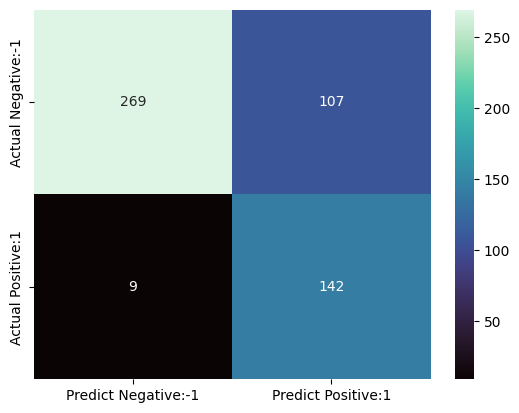

In [11]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [12]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    output = np.exp(-1 * gamma * (np.linalg.norm(x1 - x2)) ** 2)
    return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    rows, _ = X.shape
    P = matrix([[y[i] * y[j] * rbf(X[i], X[j], gamma) for j in range(rows)] for i in range(rows)])
    q = matrix(-1 * np.ones((rows, 1)))
    A = matrix([[y[i]] for i in range(len(y))])
    b = matrix(np.zeros((1, 1)))
    G = matrix(np.vstack((np.eye(rows), -1 * np.eye((rows)))))
    h = matrix(np.vstack((C * np.ones((rows, 1)), np.zeros((rows, 1)))))
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(sol["x"])
    indexes = alphas > 10 ** -5
    support_vectors = X[indexes]
    support_vector_labels = y[indexes]
    support_vector_alphas = alphas[indexes]

    return support_vectors, support_vector_labels, support_vector_alphas

In [13]:
gammas = [0.01, 0.1, 1, 10, 100]
best_gamma = None
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

# TODO: Write your code here

best_accuracy = -1
for gamma in gammas:
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C, gamma)
    this_gamma_pred = predict_labels(X_val, support_vectors, support_vector_labels, support_vector_alphas)
    this_gamma_accuracy = accuracy_score(y_val, this_gamma_pred)
    if this_gamma_accuracy > best_accuracy:
        best_accuracy = this_gamma_accuracy
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas
        best_gamma = gamma

print(best_gamma)

     pcost       dcost       gap    pres   dres
 0: -1.8276e+02 -9.2359e+02  4e+03  2e+00  5e-15
 1: -1.2934e+02 -5.7162e+02  6e+02  1e-01  4e-15
 2: -1.4020e+02 -2.1032e+02  8e+01  2e-02  3e-15
 3: -1.5709e+02 -1.8004e+02  2e+01  4e-03  3e-15
 4: -1.6178e+02 -1.7257e+02  1e+01  2e-03  3e-15
 5: -1.6459e+02 -1.6823e+02  4e+00  4e-04  4e-15
 6: -1.6568e+02 -1.6671e+02  1e+00  9e-05  3e-15
 7: -1.6608e+02 -1.6619e+02  1e-01  6e-06  4e-15
 8: -1.6613e+02 -1.6613e+02  2e-03  1e-07  4e-15
 9: -1.6613e+02 -1.6613e+02  2e-05  1e-09  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1678e+02 -8.9497e+02  4e+03  2e+00  2e-15
 1: -8.7128e+01 -5.2771e+02  5e+02  9e-02  1e-15
 2: -9.5754e+01 -1.6799e+02  8e+01  1e-02  1e-15
 3: -1.0964e+02 -1.2537e+02  2e+01  2e-03  1e-15
 4: -1.1330e+02 -1.1791e+02  5e+00  2e-04  1e-15
 5: -1.1467e+02 -1.1538e+02  7e-01  6e-06  1e-15
 6: -1.1489e+02 -1.1505e+02  2e-01  1e-06  1e-15
 7: -1.1494e+02 -1.1499e+02  5e-02  2e-15  1e-1

In [14]:
y_pred = predict_labels(X_test, best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8045540796963947
Balanced Accuracy:  0.7282918838946033
Confusion Matrix:
 [[341  35]
 [ 68  83]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [15]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, train_size=0.8, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

param_grid = {'C': Cs, 'gamma': gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.9670602858918583
Balanced Accuracy:  0.9535190699235746
Confusion Matrix:
 [[360   0   1   0   1   0]
 [  0 180   0   0   2   0]
 [  0   0 350   4   0   1]
 [  0   0  17 120   2  12]
 [  1   1   0   0 180   1]
 [  0   0   4   4   2 366]]


Implement Multiclass SVM from scratch without using ready functions (optional).

In [21]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.learning_rate * y[idx]
                    
    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

def train_one_vs_all(X, y, num_classes=6):
    svm_classifiers = []
    for class_val in range(num_classes):
        y_binary = np.where(y == class_val, 1, -1)
        svm = LinearSVM()
        svm.fit(X, y_binary)
        svm_classifiers.append(svm)
    return svm_classifiers

def predict_one_vs_all(classifiers, X):
    predictions = np.array([clf.predict(X) for clf in classifiers])
    return np.argmax(predictions, axis=0)

classifiers = train_one_vs_all(X_train, y_train, 6)
y_pred = predict_one_vs_all(classifiers, X_test)
evaluate(y_test, y_pred)

Accuracy:  0.5605966438781852
Balanced Accuracy:  0.5230723776797884
Confusion Matrix:
 [[  0   0   0   0   0   0   0]
 [ 11 348   0   3   0   0   0]
 [ 15   2 165   0   0   0   0]
 [ 32   0   0 323   0   0   0]
 [117   0   0  34   0   0   0]
 [112   3   2   0   0  66   0]
 [370   1   0   4   0   1   0]]


c:\Users\Erfan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.5605966438781852,
 0.5230723776797884,
 array([[  0,   0,   0,   0,   0,   0,   0],
        [ 11, 348,   0,   3,   0,   0,   0],
        [ 15,   2, 165,   0,   0,   0,   0],
        [ 32,   0,   0, 323,   0,   0,   0],
        [117,   0,   0,  34,   0,   0,   0],
        [112,   3,   2,   0,   0,  66,   0],
        [370,   1,   0,   4,   0,   1,   0]], dtype=int64))

# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

Accuracy:  0.8937228091982597
Balanced Accuracy:  0.8592204856408169
Confusion Matrix:
 [[359   0   2   0   1   0]
 [  0 178   0   0   4   0]
 [  0   0 333  18   0   4]
 [  1   0  30  72   2  46]
 [  2   2   0   2 161  16]
 [  0   0   9  22  10 335]]


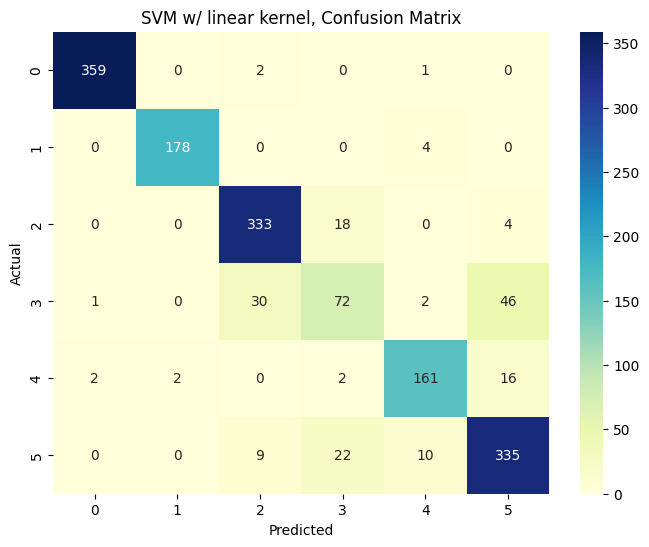

In [17]:
best_svm = SVC(kernel='linear', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM w/ linear kernel, Confusion Matrix")
plt.show()

### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part. 

Accuracy:  0.9670602858918583
Balanced Accuracy:  0.9535190699235746
Confusion Matrix:
 [[360   0   1   0   1   0]
 [  0 180   0   0   2   0]
 [  0   0 350   4   0   1]
 [  0   0  17 120   2  12]
 [  1   1   0   0 180   1]
 [  0   0   4   4   2 366]]


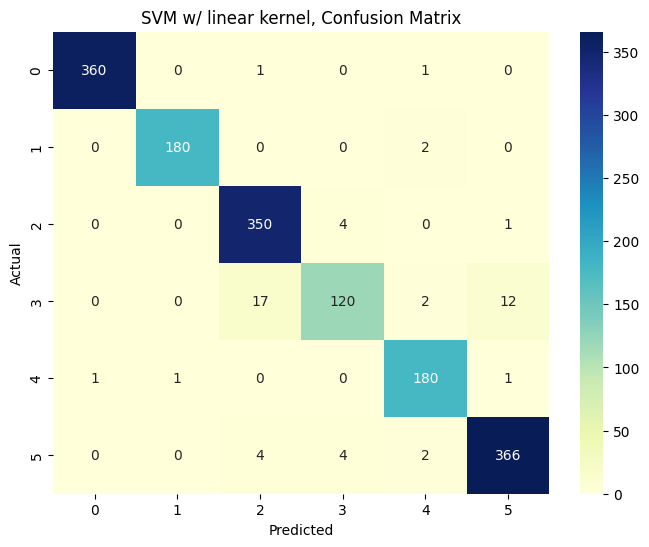

In [18]:
best_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM w/ linear kernel, Confusion Matrix")
plt.show()

### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.9683032939714108
Balanced Accuracy:  0.9598579470304863
Confusion Matrix:
 [[360   0   1   0   1   0]
 [  1 179   0   1   1   0]
 [  0   0 345   8   0   2]
 [  3   0  10 132   1   5]
 [  3   1   0   0 176   3]
 [  0   0   1   8   1 366]]


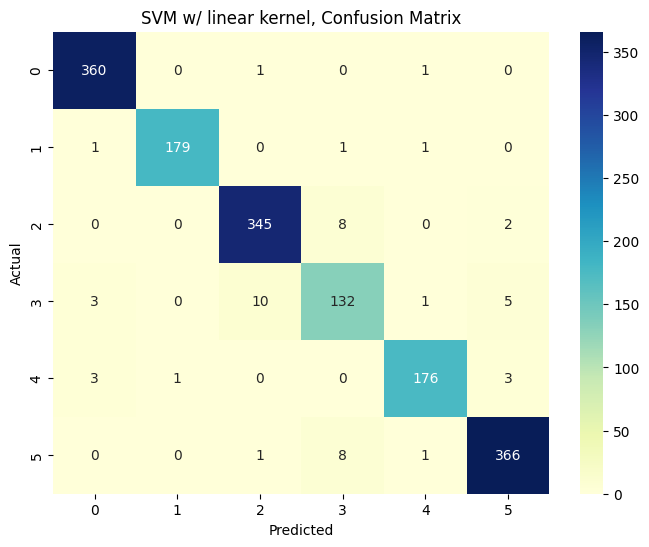

In [19]:
best_svm = SVC(kernel='poly', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM w/ linear kernel, Confusion Matrix")
plt.show()

### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts. 

Accuracy:  0.5512740832815414
Balanced Accuracy:  0.43291129127815614
Confusion Matrix:
 [[251  47  54   0   4   6]
 [129  27   3   0  20   3]
 [ 19   0 330   0   4   2]
 [  0   1  86   0   1  63]
 [ 33  36   8  36  30  40]
 [  0   1  39  80   7 249]]


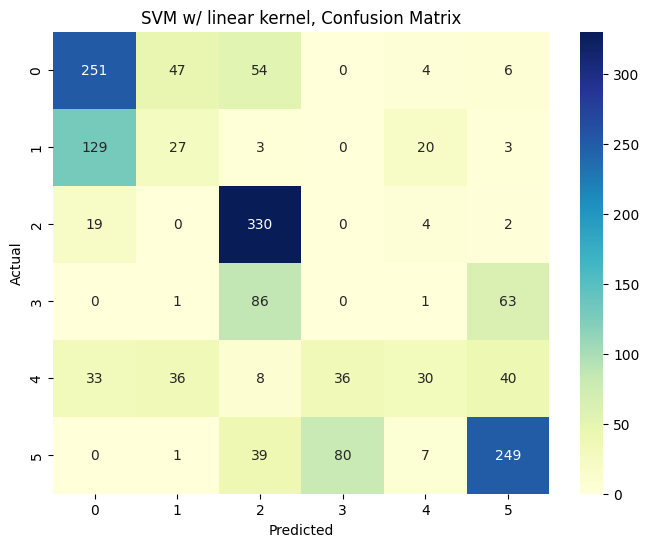

In [20]:
best_svm = SVC(kernel='sigmoid', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM w/ linear kernel, Confusion Matrix")
plt.show()

Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one? 

polynomial kernel has best accuracy and balanced accuracy, and by looking at confusion matrix we get same conclusion that this kernel is best choice. However, linear kernel can be used when data is seperable using a line, and it's fast compared to other kernels. rbf function has most flexibilty and by setting hyperparameters we can increase accuracy in the most efficient way. sigmoid kernel can not be as accurate as rbf and is more complex that linear kernels, and has lowest accuracy.